<a href="https://colab.research.google.com/github/vishnuPemmaraju/iiit_labs/blob/main/gradient_descent2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# Importing the required libraries

import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(100)
np.random.seed(100)

We can start be choosing coefficients for a second degree polynomial equation $(a x^2 + bx + c)$ that will distribute the data we will try to model.

Let's define some random x data (inputs) we hope to predict y (outputs) of.

In [36]:
def eval_2nd_degree(coeffs, x):
    """
    Function to return the output of evaluating a second degree polynomial,
    given a specific x value.

    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.

    Returns:
        y: The corresponding output y value for the second degree polynomial.

    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    return y

hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [3, 6, 2]

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree(coeffs, x)
    xs.append(x)
    ys.append(y)

**Observation:** the range of the points changes the results drastically and depends on the type of equation i.e where the roots of the polynomial lies

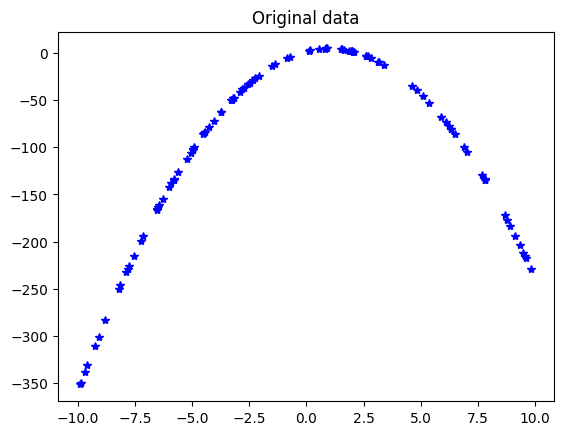

In [37]:
plt.plot(xs, ys, 'b*')
plt.title('Original data')
plt.show()

This is good, but we could improve on this by making things more realistic. You can add noise or **jitter** to the values so they can resemble real-world data.


In [38]:
def eval_2nd_degree_jitter(coeffs, x, j):
    """
    Function to return the noisy output of evaluating a second degree polynomial,
    given a specific x value. Output values can be within [y − j, y + j].

    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
        j: Jitter parameter, to introduce noise to output y.

    Returns:
        y: The corresponding jittered output y value for the second degree polynomial.

    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c

    interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max      # Generate a random number in range 0 to interval max

    while interval_min > jit_val:                 # While the random jitter value is less than the interval min,
        jit_val = random.random() * interval_max  # it is not in the right range. Re-roll the generator until it
                                                  # give a number greater than the interval min.

    return jit_val

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree_jitter(coeffs, x, 0.2)
    xs.append(x)
    ys.append(y)


In my Observation in this case of the polynomial the noise or jitter has minimum show any drastic changes int he overall result by there is a certain change of number of iterations required to find the gradient
(noise value-number of iterations required(approx))

**This values are noted for quadratic polynomial**
*   0.1-(2 iterations)
*   0.2-(sharp decrease till 5 iterations but require 50 iterations for overall stability)
*   0.5-(stabilized nearly after 50 iterations)
*   0.9-(stabilized nearly after 80 iterations)
So I felt that taking 0.1 or 0.2 will be better






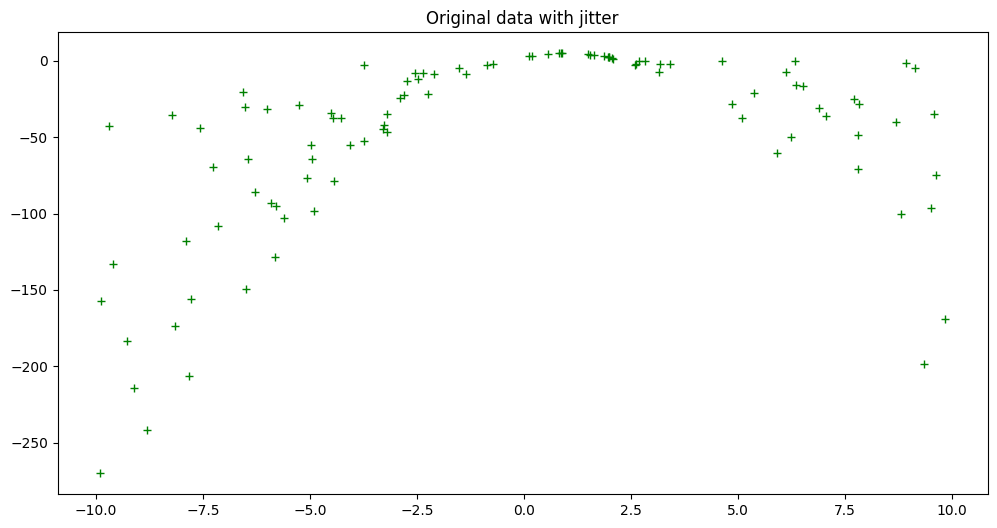

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()

We will now build our predictive model, and optimize it with gradient descent and we will try to get as close to these values as possible.

To get a quantifiable measure of how incorrect it is, we calculate the Mean Squared Error loss for the model. This is the mean value of the sum of the squared differences between the actual and predicted outputs.

$$ E = \frac{1}{n} \sum_{i=0}^n (y_i - \bar{y_i})^2 $$

In [40]:
def loss_mse(ys, y_bar):
    """
    Calculates MSE loss.

    Args:
        ys: training data labels
        y_bar: prediction labels

    Returns: Calculated MSE loss.
    """

    return sum((ys - y_bar) * (ys - y_bar)) / len(ys)

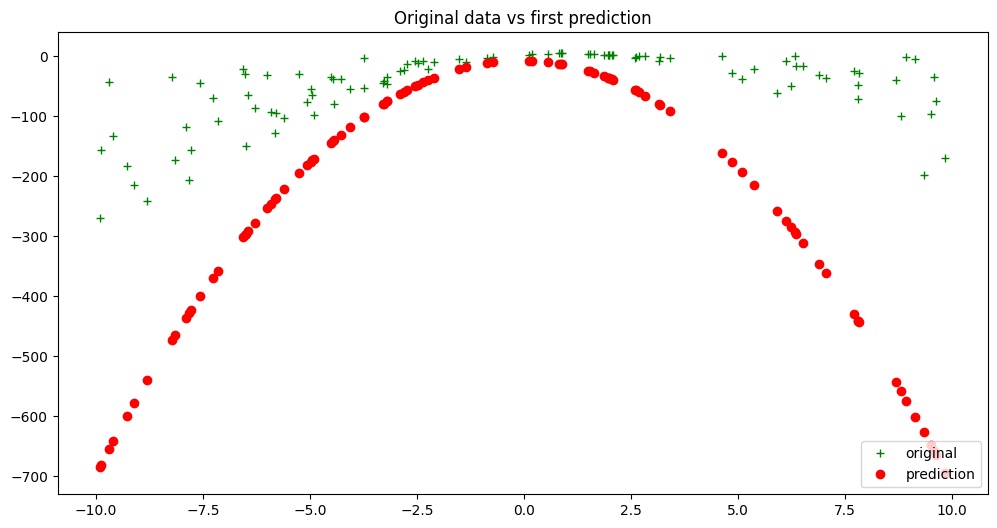

In [41]:
rand_coeffs = (random.randrange(-10, 10), random.randrange(-10, 10), random.randrange(-10, 10))
y_bar = eval_2nd_degree(rand_coeffs, hundred_xs)
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, y_bar, 'ro', label = 'prediction')
plt.title('Original data vs first prediction')
plt.legend(loc="lower right")
plt.show()

**Obseravtion 2:** The range of values taken for the random initialization of the coeffficents plays a very important role I have tried different types  of ranges and found the following inferences:
*   for uniform ranges the predictions are also uniform and there are nearly coupled to the original value we can see that from the above graph
*   ranges which is superset of range taken in the inital pts i.e (hundred_xs) is giving a smooth  descent in gradient than the range which is subset of the intial ranges i.e(-5,5) in this case.
*   For non unifrom ranges like(-10,-5),(-25,15) etc i observed that the result is very poor when compared to the uniform ranges because I found the error is rate is more in these cases



**It would be optimum to select the intial values of random coefficents same as range of intial points taken in this case I have taken (-10,10) for every coefficient as I have taken**

In [42]:
initial_model_loss = loss_mse(ys, y_bar)
initial_model_loss

68222.31873528351

We can see that the loss is quite a large number. Let’s now see if we can improve on this fairly high loss metric by optimizing the model with gradient descent.

We wish to improve our model. Therefore we want to alter its coefficients $a$, $b$ and $c$ to decrease the error. Therefore we require knowledge about how each coefficient affects the error. This is achieved by calculating the partial derivative of the loss function with respect to **each** of the individual coefficients.

In [43]:
def calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """

    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(rand_coeffs, hundred_xs)

    for x, y, y_bar in list(zip(hundred_xs, ys, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)

    return (gradient_a, gradient_b, gradient_c)   # return calculated gradients as a a tuple of its 3 parts

In [44]:
calc_grad = calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys)

lr = 0.0003
a_new = rand_coeffs[0] - lr * calc_grad[0]
b_new = rand_coeffs[1] - lr * calc_grad[1]
c_new = rand_coeffs[2] - lr * calc_grad[2]

new_model_coeffs = (a_new, b_new, c_new)
print(f"New model coeffs: {new_model_coeffs}")

# update with these new coeffs:
new_y_bar = eval_2nd_degree(new_model_coeffs, hundred_xs)
updated_model_loss = loss_mse(ys, new_y_bar)

print(f"Now have smaller model loss: {updated_model_loss} vs {initial_model_loss}")

New model coeffs: (-0.02303376782637301, -0.9401042949761271, -6.884565585266875)
Now have smaller model loss: 5892.4458669098185 vs 68222.31873528351


**Observation 3:**
Learning rate is deciding the model loss of the polynomial I have tried it with different values and noted the down the coressponding loss value


*   0.1-->251136702.84
*   0.01-->2401415.996
*   0.001-->18014.5837
*   0.0001-->4575.7151
*   0.00001-->5480.841
Here i found that there a downward curve of the loss function upto  the learning value 0.0001 but from there the loss value is increasing again aso i felt that the laerning rate shouls be near to 0.0001.Then I tried the nearer values to 0.0001 and got following values
* 0.0002-->4049.67
* 0.0003-->4028.32
* 0.0004-->4511.87
So from following values I felt that  0.0003 would be the optimum learning rate value




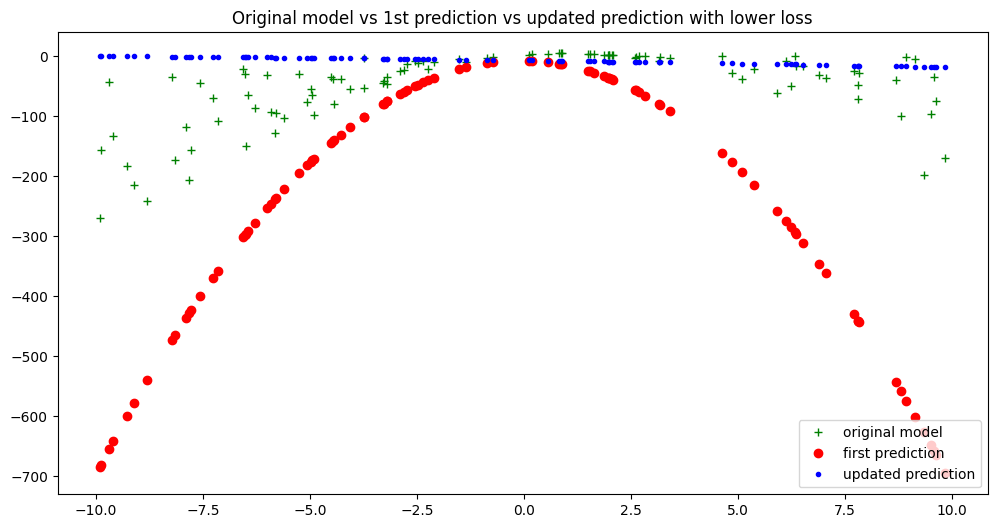

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'original model')
plt.plot(xs, y_bar, 'ro', label = 'first prediction')
plt.plot(xs, new_y_bar, 'b.', label = 'updated prediction')
plt.title('Original model vs 1st prediction vs updated prediction with lower loss')
plt.legend(loc="lower right")
plt.show()

We’re almost ready. The last step will be to perform gradient descent iteratively over a number of epochs (cycles or iterations.) With every epoch we hope to see an improvement in the form of lowered loss, and better model-fitting to the original data.

In [46]:
def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        lr: learning rate

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """
    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c

    new_model_coeffs = (a_new, b_new, c_new)

    # update with these new coeffs:
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)

    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

In [47]:
def gradient_descent(epochs, lr):
    """
    Perform gradient descent for a second degree polynomial.

    Args:
        epochs: number of iterations to perform of finding new coefficients and updatingt loss.
        lr: specified learning rate

    Returns: Tuple containing (updated_model_loss, new_model_coeffs, new_y_bar predictions, saved loss updates)

    """
    losses = []
    rand_coeffs_to_test = rand_coeffs
    for i in range(epochs):
        loss = calc_gradient_2nd_poly_for_GD(rand_coeffs_to_test, hundred_xs, ys, lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    print(losses)
    return loss[0], loss[1], loss[2], losses  # (updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)

In [48]:
GD = gradient_descent(30000, 0.0003)


[5892.4458669098185, 2491.5411698371963, 2272.287787857064, 2226.1634047186553, 2190.752847160424, 2157.2364033063695, 2125.0854938930283, 2094.2210830419554, 2064.590414502852, 2036.1440890310432, 2008.834749825691, 1982.6169371692201, 1957.4470091393853, 1933.2830687435044, 1910.0848941415725, 1887.8138716686976, 1866.4329315359898, 1845.906486102332, 1826.2003706141993, 1807.2817863148696, 1789.1192458282653, 1771.682520726498, 1754.9425911938054, 1738.8715977030524, 1723.442794624327, 1708.6305056884014, 1694.4100812308707, 1680.7578571457782, 1667.651115480406, 1655.0680466055594, 1642.9877128984072, 1631.3900138773686, 1620.2556527309914, 1609.566104185112, 1599.303583654756, 1589.45101762943, 1579.9920152424943, 1570.910840977261, 1562.19238846437, 1553.822155326829, 1545.7862190308028, 1538.0712137019502, 1530.66430786872, 1523.5531830955138, 1516.726013470153, 1510.1714459114999, 1503.8785812644253, 1497.836956150647, 1492.036525545227, 1486.4676460496976, 1481.1210598339799, 

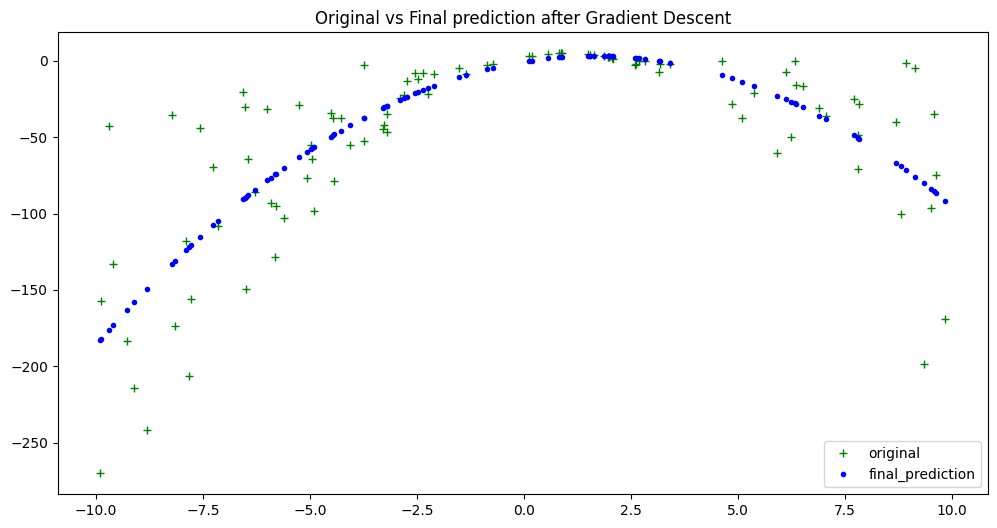

In [49]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, GD[2], 'b.', label = 'final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

This trained model is showing vast improvements after it’s full training cycle. We can examine further by inspecting its final predicted coefficients $a$, $b$ and $c$.

In [50]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")

Final Coefficients predicted: (-1.4015266885414879, 4.539816516485608, -0.590255886479888)
Original Coefficients: [-3, 6, 2]


Not too far off! A big improvement over the initial random model. Looking at the plot of the loss reduction over training offers further insights.


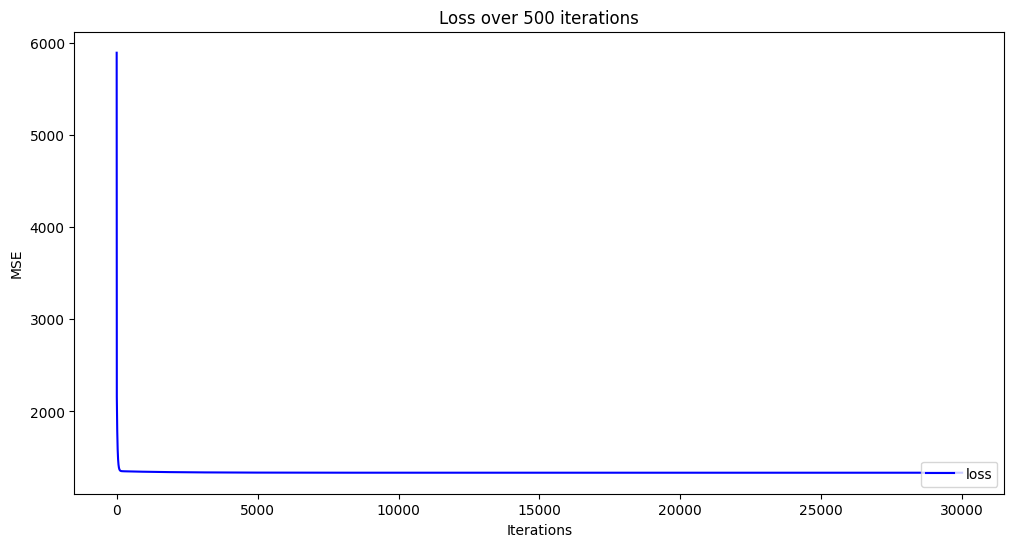

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(GD[3], 'b-', label = 'loss')
# plt.xlim(0,50)
plt.title('Loss over 500 iterations')
plt.legend(loc="lower right")
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

We observe that the model loss reached close to zero, to give us our more accurate coefficients. We can also see there was no major improvement in loss after about 100 epochs. An alternative strategy would be to add some kind of condition to the training step that stops training when a certain minimum loss threshold has been reached. This would prevent excessive training and potential over-fitting for the model.

# Observations & Inferences Of The Lab



1.   **Change the coefficients array and try a different polynomial instead of our $x^2$.**

  **ANSWER :** I have tried it with a polynomial $3x^2$+$6x$+2 and got the result  sharply converging nearly before 100 iterations with the loss value convering to 0.73 abd at the end of 30000 iteration the loss is 0.02  where it was 4048.43 in beginning.
2.   **Increase/decrease the learning rate to see how many iterations will be take to coverge. Does it even converge on a huge learning rate?**

  **Answer :** I have tried different values of the learning rates and described some of them above and found optimum learning rate by trail and error method.
  I have found that the it is converging at any higher values of the learning rates also,But I found a intresting combination of jitter and learning rate and learned that the higher values of jitter along with higer learning rate is converging the result faster **But the loss value of the function is higher in this case**

  * with the learning rate being 0.1 and noise value ranged 0.9 the result is getting converged even before 25 iterations but the final loss is 33.27 at the end of 1000 iterations the final loss is still around 20

  * with optimum  learning rate i.e(0.0003) and optimum jitter 0.2 The final loss is 3.90 approximately after 1000 iterations and this nearly converges to 0.6 after 4500 iterations and the end of 30000 iterations the error is 0.02

3. **Take a degree 5 polynomial with 5 roots and try different initializations, instead of random ones. Does it converge on different values for different initializations? Why does initialization not matter in our case of $x^2$?**

  The initialization is very important in the greater degrees as the gradient descent will not converge easily as it done for the  x2  degree polynomial and the learning rate must not be too small and even should not be too high to work with

* intializations doesn't matter to a very large extent in case of quadratic equation because of less possiblities in the variations as there will be only 3 varaibles to be found,But for the polynomials of higher degree the initailizatons are so important as there are many possible outcomes to different coefficients
I tried different ways in converging the descent but I couldn't find the converged result but I observed that in case of the higher degree polynomial learning rate should be less as it has many coefficent values to take care of

4. **Can you modify the algorithm to find a maxima of a function, instead of a minima?**
yes we can modify the function to get the maxima.If we understand the code in the line of adding jitter to the points we have taken a range and added the points whose value is less than the minimum value this leads to find the minima of the function as shown below

  * while interval_min > jit_val:
  
      jit_val = random.random()

* To get the maxima we should add the points whose value is more than the maximum value i.e (x+j) so we modify the above code as follows

  * while interval_max <jit_val:

    jit_val = random.random()



